# EnKF Assumption Experiments

### Keiran Suchak

Assumptions to test:
* Normality of prior
* Normality of likelihood
* Subsequent normality of posterior

This notebook will make use of the `multivariate_normality()` function from the `pingouin` package to perform multidimensional normality tests.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pingouin as pg
import seaborn as sns
import sys

%matplotlib inline

In [2]:
sys.path.append('../../stationsim/')

In [3]:
from ensemble_kalman_filter import EnsembleKalmanFilter, EnsembleKalmanFilterType
from stationsim_gcs_model import Model

In [4]:
np.random.seed(28)

## Functions

In [5]:
def tidy_dataframe(df, independent_col: str, dependent_cols: list):
    output = list()
    
    for i, row in df.iterrows():
        for col in dependent_cols:
            d = {independent_col: row[independent_col],
                 'variable':  col,
                 'value': row[col]}
            output.append(d)
    
    output = pd.DataFrame(output)
    return output

## Experiment 0: Testing `pg.multivariate_normality()`

Create a sample of 5000 $x$-$y$ coordinates from a 2-dimensional normal distribution.

In [6]:
mean = [0, 0]
cov = [[1, 0], [0, 100]]

x, y = np.random.multivariate_normal(mean, cov, 5000).T

Plot samples in $x$-$y$ space.

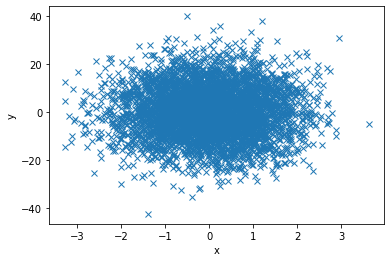

In [7]:
plt.figure()
plt.plot(x, y, 'x')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Test for normality.

In [8]:
X = pd.DataFrame({'x': x, 'y': y})
pg.multivariate_normality(X, alpha=0.05)

HZResults(hz=0.7628312275186067, pval=0.660947651865469, normal=True)

The test did not find sufficient evidence to reject the null hypothesis, i.e. the data are normally distributed.

Let us now consider data drawn from a distribution that is not gaussian.
In this case, we draw the $x$-$y$ coordinates from two uniform distributions, \[0.0, 1.0\).

In [9]:
x, y = np.random.random_sample((2, 5000))

Plot samples in $x$-$y$ space.

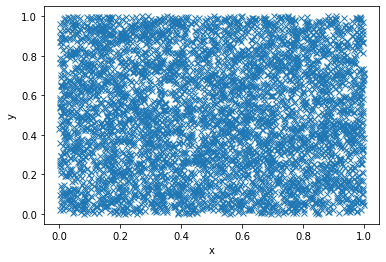

In [10]:
plt.figure()
plt.plot(x, y, 'x')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Test for normality.

In [11]:
X = pd.DataFrame({'x': x, 'y': y})
pg.multivariate_normality(X, alpha=0.05)

HZResults(hz=39.45719019470325, pval=1.7016424202324236e-72, normal=False)

The test correctly finds sufficient evidence to reject the null hypothesis that the data are normally distributed.

We can make a couple of functions to generate normally- and uniformly-distributed samples of arbitrary size and check that the test works for different sample sizes.

In [12]:
def normal_sample_2d(N):
    mean = [0, 0]
    cov = [[1, 0], [0, 100]]

    x, y = np.random.multivariate_normal(mean, cov, N).T
    X = pd.DataFrame({'x': x, 'y': y})
    return X

In [13]:
def uniform_sample_2d(N):
    x, y = np.random.random_sample((2, N))
    X = pd.DataFrame({'x': x, 'y': y})
    return X

In [14]:
def test_multidim_normality(X):
    t = pg.multivariate_normality(X)
    return t.normal

Now we can run through a collection of different sample sizes, each time generating that number of random samples from both normal and uniform distributions and testing whether `pg.multivariate_normality()` found the samples to be normally distributed, or whether sufficient evidence was found to reject the null hypothesis.

The sample sizes to be used are `[10, 20, 50, 100, 200, 500, 1000, 2000]`.
This selection has been chosen to observe how the test performs on different scales of sample size.

In each case, the testing process shall be run $20$ times to account for the randomness of the samples and the fact that the test may incorrectly consider normally distributed data to be non-normal (or vice-versa).

In [15]:
results = list()
sample_sizes = [10, 20, 50, 100, 200, 500, 1000, 2000]
n_runs = 20

for ss in sample_sizes:
    for _ in range(n_runs):
        d = {'sample_size': ss}
        normal_sample = normal_sample_2d(ss)
        uniform_sample = uniform_sample_2d(ss)
        d['gaussian'] = test_multidim_normality(normal_sample)
        d['non-gaussian'] = test_multidim_normality(uniform_sample)
        results.append(d)        

Let's convert these results into a dataframe.

In [16]:
results = pd.DataFrame(results)
results.head()

,sample_size,gaussian,non-gaussian
0,10,True,True
1,10,True,True
2,10,True,True
3,10,True,True
4,10,True,True


We can now find the proprtion of cases in each scenario for which the test correctly accepted/rejected the null hypothesis.

In [17]:
proportions = list()
for ss in sample_sizes:
    tdf = results.loc[results['sample_size']==ss, ]
    d = {'sample_size': ss}
    d['gaussian'] = tdf['gaussian'].sum() / len(tdf['gaussian'])
    d['non-gaussian'] = tdf['non-gaussian'].sum() / len(tdf['non-gaussian'])
    proportions.append(d)

Again, converting this to a dataframe.

In [18]:
proportions = pd.DataFrame(proportions)
proportions.head()

,sample_size,gaussian,non-gaussian
0,10,1.00,1.00
1,20,0.95,0.85
2,50,1.00,0.35
3,100,0.95,0.00
4,200,0.95,0.00


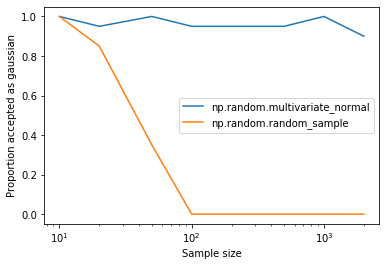

In [19]:
plt.figure()
plt.semilogx(proportions['sample_size'], proportions['gaussian'],
             label='np.random.multivariate_normal')
plt.semilogx(proportions['sample_size'], proportions['non-gaussian'],
             label='np.random.random_sample')
plt.xlabel('Sample size')
plt.ylabel('Proportion accepted as gaussian')
plt.legend()
plt.show()

From the above figure, we can see that the test correctly identifies data from `np.random.multivariate_normal()` as gaussian the majority of the time for all sample sizes.
We can also see that, for very small sample sizes (i.e. $N<50$), the test typically does not find sufficient evidence to reject the null hypothesis of normality for non-gaussian data.
We should, therefore, ensure that our sample sizes are sufficiently large when using the test with data from the Ensemble Kalman Filter.

It is also worth considering how this scales with the dimensions of the data - when working with state vectors from the Ensemble Kalman Filter, we consider our sample size to be the filter's ensemble size and twice the model population size to be our number of dimensions.

In order to test this, we will need updated version of the functions used to generate samples - the new versions of these functions should generalise such that we can generate $m$-dimensional data samples.

In [20]:
def __convert_to_df(Y, m):
    d = {'var_{0}'.format(i): Y[i] for i in range(m)}
    X = pd.DataFrame(d)
    
    return X

In [21]:
def normal_sample_d(N, m):
    mean = np.zeros(m)
    cov = np.identity(m)

    Y = np.random.multivariate_normal(mean, cov, N).T
    X = __convert_to_df(Y, m)
    return X

In [22]:
def uniform_sample_d(N, m):
    Y = np.random.random_sample((m, N))
    X = __convert_to_df(Y, m)
    return X

Now that we have constructed the functions, let us test them out with $200$ samples from $10$-dimensional distribtutions.

We can start by sampling from the multivariate normal distribution:

In [23]:
z = normal_sample_d(200, 10)
z

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9
0,1.687328,-0.601222,-0.706249,0.144170,0.546775,1.070943,1.043151,-0.377107,1.851523,0.263585
1,-0.528339,-0.166505,2.152215,0.590143,1.081139,-0.412480,-1.866688,-0.407997,-1.912106,2.271592
2,1.005510,0.168954,-1.490664,-0.279071,1.870033,-0.998066,-1.549099,0.451850,0.151120,-0.624163
3,-0.037313,0.689826,1.882012,0.006862,0.649231,-0.811971,-0.128205,-0.423291,-0.783849,-0.670259
4,1.290394,0.727855,-2.199012,0.760069,-0.438210,-0.880422,0.134222,1.261142,-1.720589,0.028748
...,...,...,...,...,...,...,...,...,...,...
195,0.214645,2.050598,-1.094754,0.066789,0.057136,-1.320391,0.173365,-0.359608,-0.142546,-1.137031
196,0.895578,1.942050,-1.267664,-0.953574,1.113474,-0.165254,0.590656,-1.945826,0.059130,1.866977
197,0.006631,-0.076036,0.909139,-0.081464,0.050227,-1.811477,-0.748194,-0.955952,0.950684,-0.725464
198,-0.545449,1.020485,0.928982,-0.750140,0.915725,-0.899527,0.498246,0.517510,-2.225398,-1.710302


In [24]:
z.shape

(200, 10)

And just to check, we can plot the first $2$ dimensions.

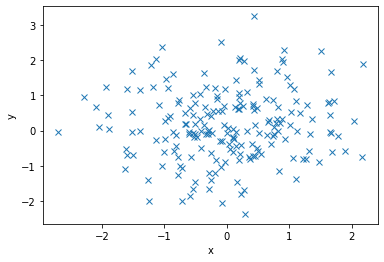

In [25]:
plt.figure()
plt.plot(z['var_0'], z['var_1'], 'x')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Similarly we can sample from the uniform distribution.

In [26]:
z = uniform_sample_d(200, 10)
z

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9
0,0.234310,0.052337,0.332883,0.481058,0.397050,0.500222,0.277590,0.143213,0.928296,0.122062
1,0.284160,0.448430,0.620089,0.174237,0.430106,0.911394,0.716964,0.202981,0.974743,0.460887
2,0.346948,0.942368,0.495045,0.890359,0.849036,0.570416,0.928149,0.750206,0.397849,0.387652
3,0.214886,0.716198,0.358374,0.639442,0.626245,0.587106,0.131403,0.504177,0.347262,0.938171
4,0.213942,0.888357,0.124475,0.992026,0.325270,0.678464,0.659926,0.371217,0.165329,0.708121
...,...,...,...,...,...,...,...,...,...,...
195,0.738126,0.825313,0.028121,0.098696,0.876954,0.206354,0.742311,0.968642,0.972727,0.836569
196,0.724200,0.080882,0.151249,0.551052,0.703864,0.200919,0.376314,0.396449,0.856545,0.899819
197,0.140708,0.955602,0.072969,0.999228,0.952673,0.219242,0.762098,0.011882,0.015889,0.428968
198,0.319700,0.830251,0.084190,0.819230,0.277018,0.615895,0.743925,0.290473,0.587178,0.904584


And we can, again, plot the first $2$ dimensions.

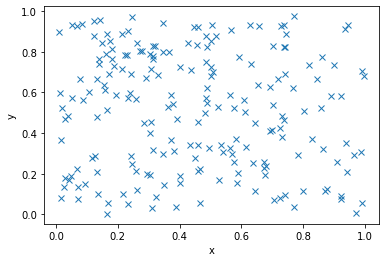

In [27]:
plt.figure()
plt.plot(z['var_0'], z['var_1'], 'x')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Well it looks like these functions work!
Now we can make use of them in conjunction with `pg.multivariate_normality()` to see how the normality test responds to different population sizes and ensemble sizes (otherwise referred to as different dimensionalities and sample sizes).

In [28]:
results = list()
sample_sizes = [50, 100, 200, 500, 1000]
dimensionalities = list(range(5, 105, 5))
n_runs = 20

for ss in sample_sizes:
    for dimensionality in dimensionalities:
        print(f'Running sample size={ss}, dimensionality={dimensionality}')
        for _ in range(n_runs):
            # Make dictionary for gaussian data
            normal_sample = normal_sample_d(ss, dimensionality)
            test_result = test_multidim_normality(normal_sample)
            d = {'sample_size': ss,
                 'dimensionality': dimensionality,
                 'kind': 'gaussian',
                 'result': test_result}
            results.append(d)
            
            # Make dictionary for non-gaussian data
            uniform_sample = uniform_sample_d(ss, dimensionality)
            test_result = test_multidim_normality(uniform_sample)
            d = {'sample_size': ss,
                 'dimensionality': dimensionality,
                 'kind': 'non-gaussian',
                 'result': test_result}
            results.append(d)

Running sample size=50, dimensionality=5
Running sample size=50, dimensionality=10
Running sample size=50, dimensionality=15
Running sample size=50, dimensionality=20
Running sample size=50, dimensionality=25
Running sample size=50, dimensionality=30
Running sample size=50, dimensionality=35
Running sample size=50, dimensionality=40
Running sample size=50, dimensionality=45
Running sample size=50, dimensionality=50
Running sample size=50, dimensionality=55
Running sample size=50, dimensionality=60
Running sample size=50, dimensionality=65
Running sample size=50, dimensionality=70
Running sample size=50, dimensionality=75
Running sample size=50, dimensionality=80
Running sample size=50, dimensionality=85
Running sample size=50, dimensionality=90
Running sample size=50, dimensionality=95
Running sample size=50, dimensionality=100
Running sample size=100, dimensionality=5
Running sample size=100, dimensionality=10
Running sample size=100, dimensionality=15
Running sample size=100, dimensi

Convert results to a dataframe.

In [29]:
results = pd.DataFrame(results)
results.head()

,sample_size,dimensionality,kind,result
0,50,5,gaussian,True
1,50,5,non-gaussian,False
2,50,5,gaussian,True
3,50,5,non-gaussian,False
4,50,5,gaussian,True


In [30]:
results['dimensionality'].unique()

array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100])

We now wish to visualise how the number of 
To do this, we first create a filtered dataset where we filter out the rows for which the tests returned false.

In [31]:
results_f = results.loc[results['result']==True, ['sample_size', 'dimensionality', 'kind']]
results_f.head()

,sample_size,dimensionality,kind
0,50,5,gaussian
2,50,5,gaussian
4,50,5,gaussian
6,50,5,gaussian
8,50,5,gaussian


In [32]:
results_f['dimensionality'].unique()

array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55])

We can now create our kde-plot, segregating the data for gaussian and non-gaussian samples.

/home/ksuchak1990/miniconda3/envs/dust/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


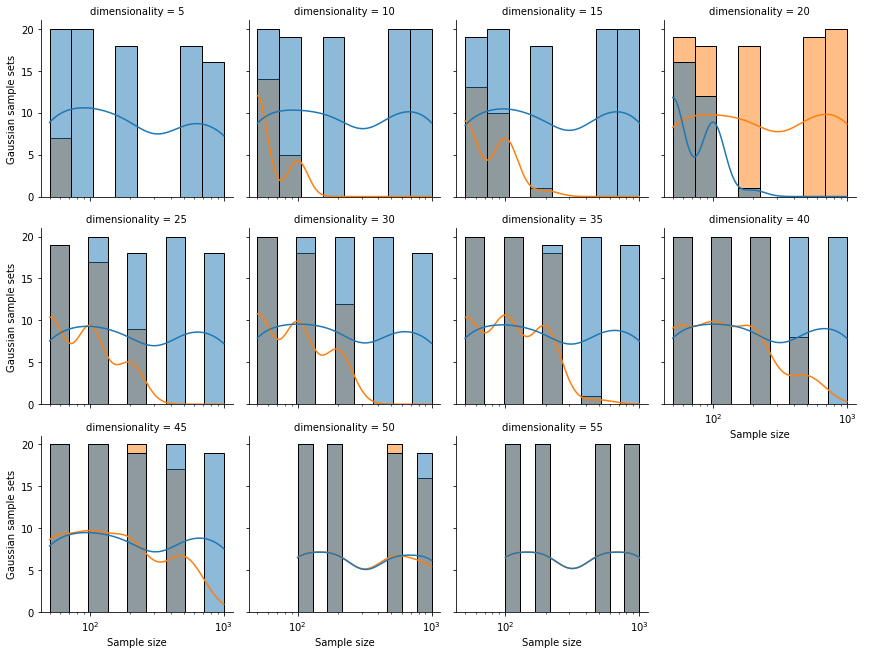

In [33]:
g = sns.FacetGrid(results_f, col='dimensionality', col_wrap=4)
g.map_dataframe(sns.histplot, x='sample_size', hue='kind', kde=True, log_scale=True)
g.set_axis_labels('Sample size', 'Gaussian sample sets')
g.add_legend()

## Experiment 1: Pure forecasting

In this experiment, we will not be assimilating any data, i.e. each step of the model ensemble will only consist of the forecast process.
Following each forecast step, the ensemble will be tested for normality using the `multivariate_normality()` function from the `pingouin` package.
In order to keep the process simple at this stage, a small population of agents will be used, allowing us to use a large ensemble size.
This will act as a preliminary experiment towards demonstrating the normality of the ensemble prior distribution.

In [34]:
results = list()

# Set up filter parameters
ensemble_size = 50
pop_size = 2

state_vec_length = 2 * pop_size

# Initialise filter with StationSim and params
filter_params = {'vanilla_ensemble_size': ensemble_size,
                 'state_vector_length': state_vec_length,
                 'mode': EnsembleKalmanFilterType.STATE}
model_params = {'pop_total': pop_size,
                'station': 'Grand_Central',
                'do_print': False}
enkf = EnsembleKalmanFilter(Model, filter_params, model_params,
                            filtering=False, benchmarking=True)


Running Ensemble Kalman Filter...
max_iterations:	None
ensemble_size:	None
assimilation_period:	None
filter_type:	EnsembleKalmanFilterType.STATE


../../stationsim/ensemble_kalman_filter.py:134: RuntimeWarning: EnKF received unexpected vanilla_ensemble_size attribute.
  warns.warn(w, RuntimeWarning)


In [35]:
while enkf.active:
    enkf.baseline_step()
    results.append(enkf.vanilla_state_ensemble.copy())

In [36]:
len(results)

2122

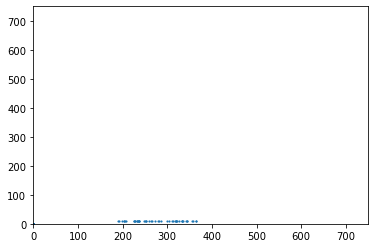

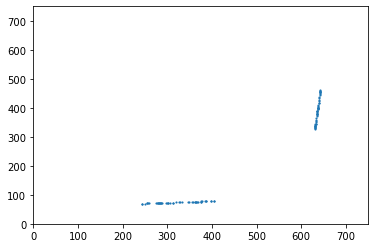

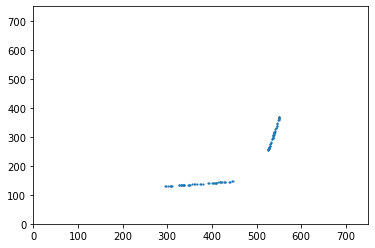

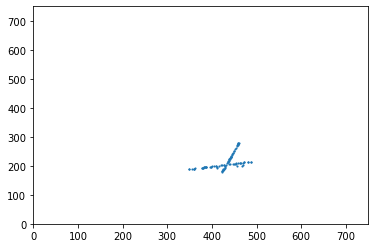

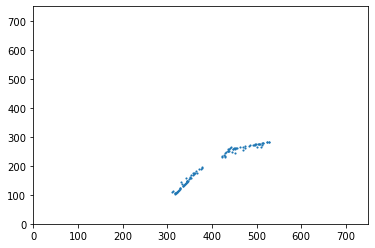

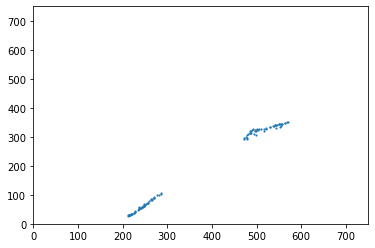

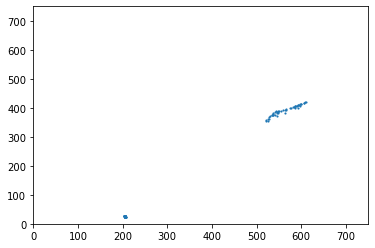

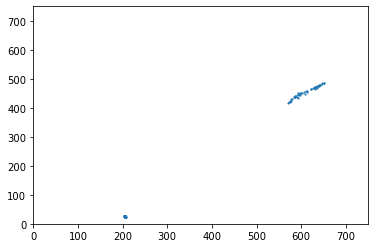

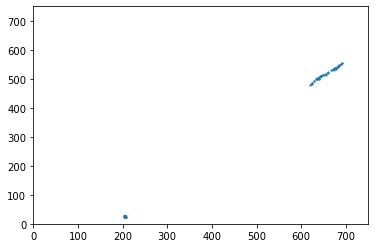

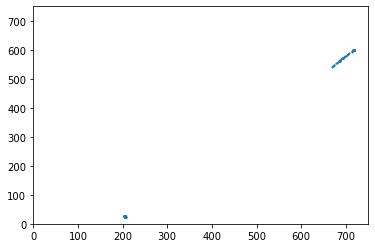

In [37]:
all_xs = list()
all_ys = list()

for i in range(10, len(results), len(results)//10):
    state = results[i]
    xs = state[::2]
    ys = state[1::2]
    all_xs.append(xs)
    all_ys.append(ys)

    plt.figure()
    plt.scatter(xs, ys, s=5, marker='.')
    plt.xlim((0, 750))
    plt.ylim((0, 750))
    plt.show()

In [38]:
norm_results = list()

for state in results:
    stateT = state.T
    normality = pg.multivariate_normality(stateT, alpha=1)
    norm_results.append(normality.normal)

In [39]:
sum(norm_results)

0

In [40]:
print(all_xs[0])

[[228.88469461 250.23091003 332.67042008 258.2150509  320.14141225
  363.5982015  231.68441584 226.16312814 279.44168947 341.83689415
  272.17471517 335.69155521 316.55075068 332.2259823  345.30626522
  236.46059344 189.80375316 318.53057512 205.3755225  309.93851659
  325.47786109 264.15072214 311.80111888 286.30333628 197.5840398
  321.703914   225.09989895 237.83950048 356.61316975 253.37496376
  344.91232138 356.01832616 228.82720716 251.57372444 320.47135956
  202.95910641 265.22178168 332.11453001 247.44247007 280.96369628
  364.89121626 233.89318163 208.28627228 231.23021665 236.84481459
  302.96342781 234.40826459 300.48404579 190.95648569 203.60500019]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.   

In [41]:
print(all_ys[0])

[[10.2415285  10.29113055 10.48461501 10.30977605 10.45521535 10.55671628
  10.24801091 10.23523445 10.35952625 10.50606929 10.34246991 10.49169212
  10.44677842 10.48357344 10.5141736  10.25908673 10.15194789 10.45143087
  10.18742294 10.43123326 10.46774607 10.32366444 10.43561307 10.37564792
  10.16963365 10.45888544 10.2327776  10.26228826 10.54051196 10.29846763
  10.51325385 10.53912948 10.24139547 10.29426332 10.45599042 10.18189774
  10.32617271 10.48331223 10.28462944 10.36310103 10.55970955 10.25313034
  10.1940879  10.24695875 10.25997864 10.41482793 10.25432484 10.40899579
  10.15456315 10.18337389]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          

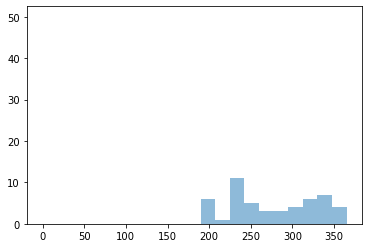

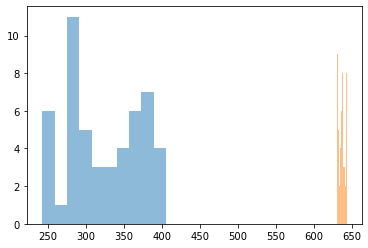

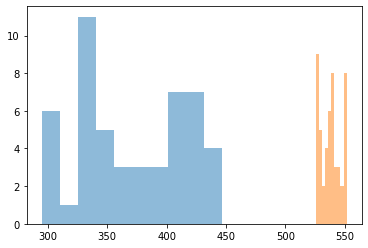

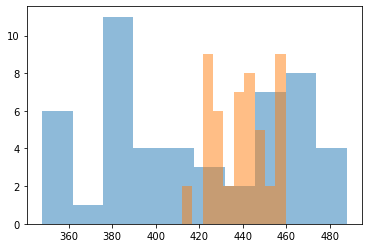

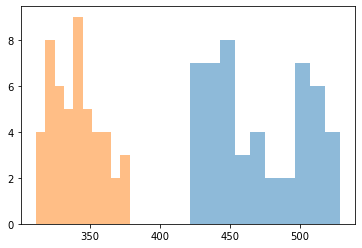

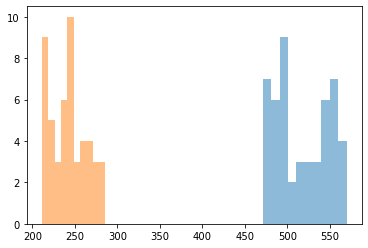

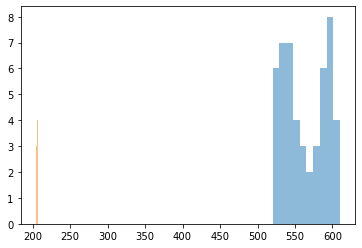

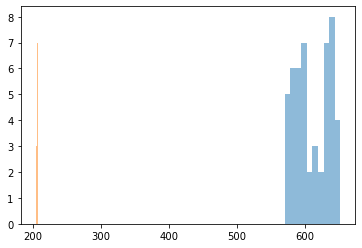

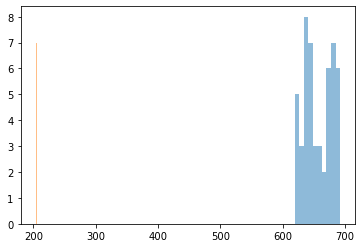

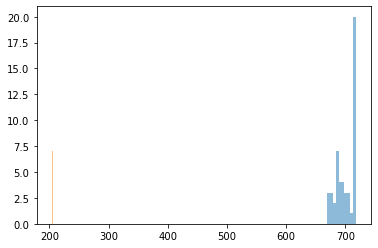

In [44]:
for xs in all_xs:
    plt.figure()
    for x in xs:
        plt.hist(x, alpha=0.5)
    plt.show()

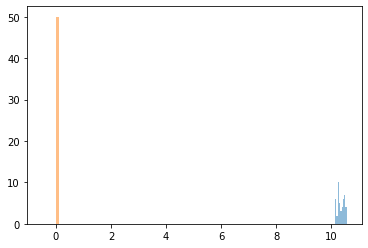

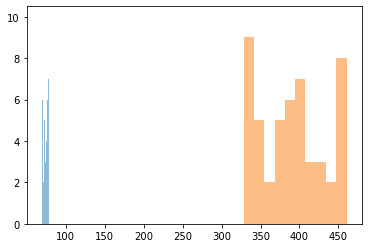

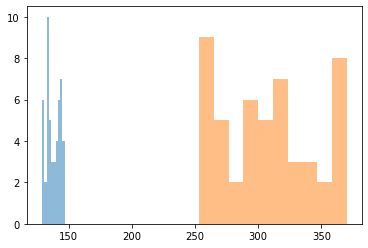

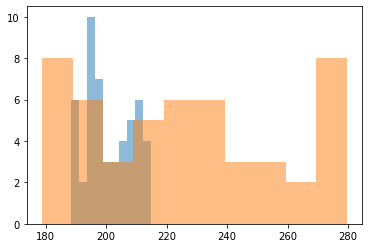

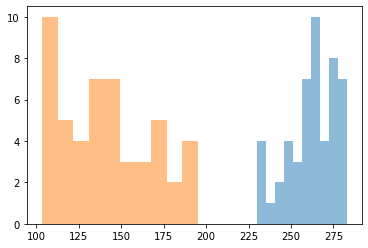

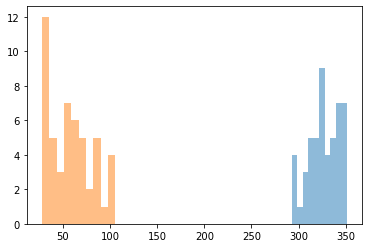

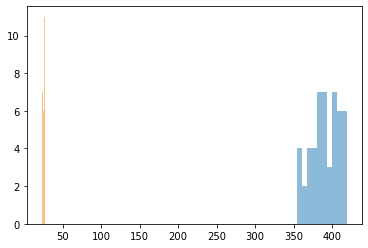

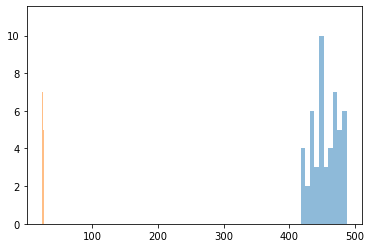

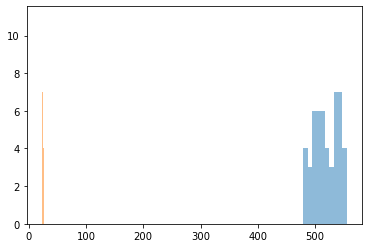

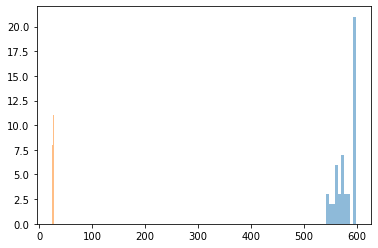

In [45]:
for ys in all_ys:
    plt.figure()
    for y in ys:
        plt.hist(y, alpha=0.5)
    plt.show()